# Neural network inference via invariant prediction, part trois
Here we infer a set of connections in the presence of hidden units by taking advantage of the different statistics exhibited by direct and indirect connections under changes in environment (common input).

In part 2 we generated a lot of different spiking data using the method from 

`"Emergence of network structure due to spike-timing-dependent plasticity in recurrent neuronal networks. I. Input selectivity–strengthening correlated input pathways." Matthieu GilsonEmail authorAnthony N. BurkittDavid B. GraydenDoreen A. ThomasJ. Leo van Hemmen. Biological Cybernetics
August 2009, Volume 101, Issue 2, pp 81–102`

Here we infer the connectivity of the 'observed' units using Granger causality. (To show it's weakness in the case of hidden units)

In [1]:
%Add things to path
clear
startup

We load a few networks of different sizes and estimate their connectivity using Granger causality

In [2]:
%Load data
param_path = './output_V4/netsim_n_30_q_21_t_600.mat';
spiking_path = './output_V4/netsim_n_30_q_21_t_600_spiketimes_batch_1.mat';

load(spiking_path);
load(param_path);

%Bin spikes
ii = p.pp;

if length(ii) == 0
    ii = 1:p.N;
end

binsize = 0.01; %in seconds
nK = 20; %length of spike history filter, in units of binsize

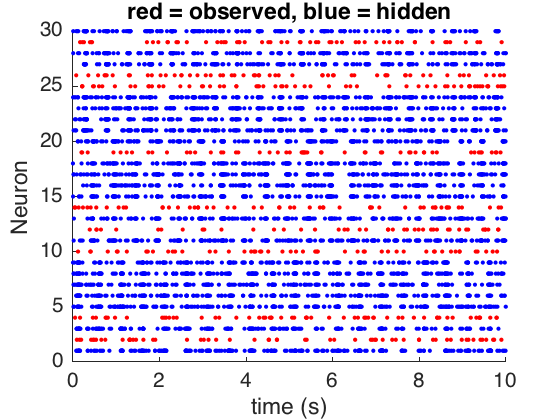

In [3]:
%Plot some rasters
hold on 
rsT = 10;
for n = 1:p.N
    t = spiketimes{n};
    t = t(t < rsT);
    c = [0, 0, 1];
    if any(ii == n)
        c = [1, 0, 0];
    end
    plot(t, n*ones(1,length(t)), '.', 'Color', c)
end
ylabel('Neuron')
xlabel('time (s)')
title('red = observed, blue = hidden')

We observe that the hidden neurons (receiving period stimulus) fire at a much higher rate than the observed neurons. I wonder then if the hidden inputs will overall be much stronger than the observed connections and will drown out their effect. 

In [5]:
%Truncate to the smaller set of neurons
spiketimes = spiketimes(ii);

%Bin spike times
N = length(spiketimes);
sim_time = time(2);

%Chop in half...
sim_time = sim_time/4;

T = round(sim_time/binsize);

%S -- spike trains -- N x T
S = zeros(N,T);
for n = 1:length(ii)
    i = ii(n);
	for idx = 1:length(spiketimes{n})
		t = max(1,round(spiketimes{n}(idx)/binsize));
		if t <= T
			S(n,t) = S(n,t) + 1;
		end
	end
end

In [50]:
Jii = Jtraj(ii,ii,2);

Prepare data to fit GLM with

In [6]:
const = 'on';
nK_pos = 0;
%Load test preprocessed data
processed.binnedspikes = S'; 
processed.rates = processed.binnedspikes/binsize;
processed.binsize = binsize;
processed.tspks = spiketimes;
processed.unitnames = {};
processed.torque = zeros(T, 2);
processed.dtorque = zeros(T, 2);
processed.ddtorque = zeros(T, 2);
for n = 1:N
    processed.unitnames{n} = num2str(ii(n));
end
data = filters_sprc_pos_network(processed, nK, nK_pos);

In [52]:
model = MLE_glmfit_network(data, const);

Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done


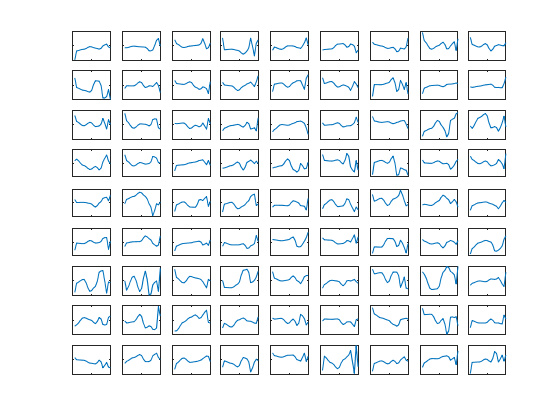

In [53]:
rcn = size(data.rcbasis,1);
tn = size(data.rcbasis,2);
sumconn = zeros(N,N);
for i = 1:N
    for j = 1:N
        subplot(N,N,(i-1)*N+j)
        jj = (((j-1)*rcn+1):(j*rcn))+1;
        tt = binsize*(1:tn)-binsize*tn;
        filter = data.spbasis*model.b_hat(i,jj)';
        plot(tt,filter)
        set(gca,'YTickLabel','')
        set(gca, 'XTickLabel', '')
        sumconn(i,j) = sum(abs(filter));
    end
end

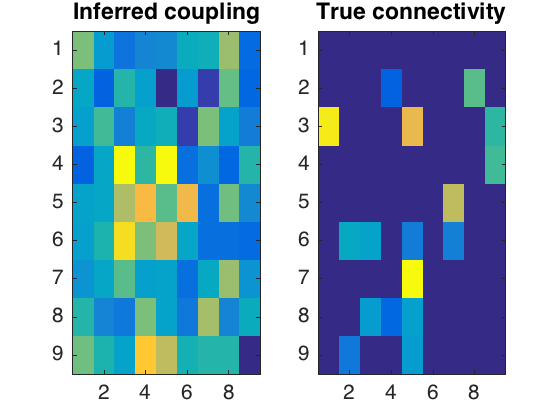

In [54]:
%Plot a heatmap of the sum of the interactions
subplot(1,2,1)
imagesc(sumconn);
title('Inferred coupling')
subplot(1,2,2)
imagesc(Jii);
title('True connectivity')

Resample data from data and refit model a bunch of times, to see if this helps... 

In [60]:
nS = 10;
n = size(data.X,1);
meanmodel = model;
meanmodel.b_hat = zeros(size(model.b_hat));
for s = 1:nS
    resampled = data;
    j = randsample(1:n, floor(n*0.9));
    resampled.X = data.X(j,:);
    resampled.y = data.y(:,j);
    resampled.torque = data.torque(j,:);
    resampled.dtorque = data.dtorque(j,:);
    resampled.ddtorque = data.ddtorque(j,:);
    model = MLE_glmfit_network(resampled, const);
    meanmodel.b_hat = meanmodel.b_hat + model.b_hat/nS;
end

Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fit

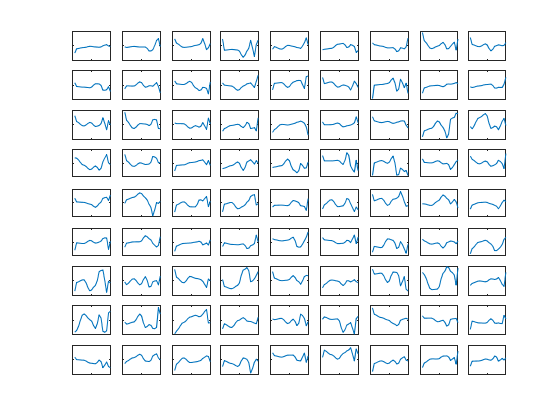

In [61]:
rcn = size(data.rcbasis,1);
tn = size(data.rcbasis,2);
sumconn = zeros(N,N);
for i = 1:N
    for j = 1:N
        subplot(N,N,(i-1)*N+j)
        jj = (((j-1)*rcn+1):(j*rcn))+1;
        tt = binsize*(1:tn)-binsize*tn;
        filter = data.spbasis*meanmodel.b_hat(i,jj)';
        plot(tt,filter)
        set(gca,'YTickLabel','')
        set(gca, 'XTickLabel', '')
        sumconn(i,j) = sum(abs(filter));
    end
end

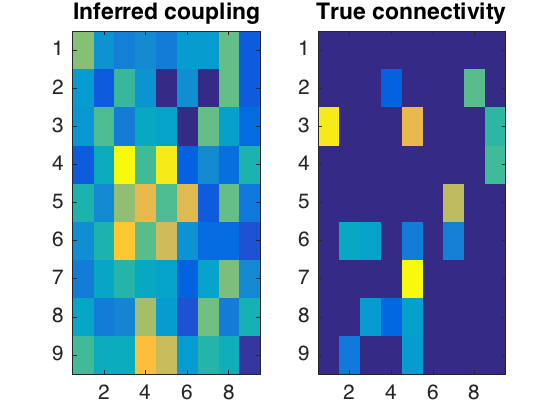

In [62]:
%Plot a heatmap of the sum of the interactions
subplot(1,2,1)
imagesc(sumconn);
title('Inferred coupling')
subplot(1,2,2)
imagesc(Jii);
title('True connectivity')

Run Granger causality on the small networks. With fewer spikes. Save the results

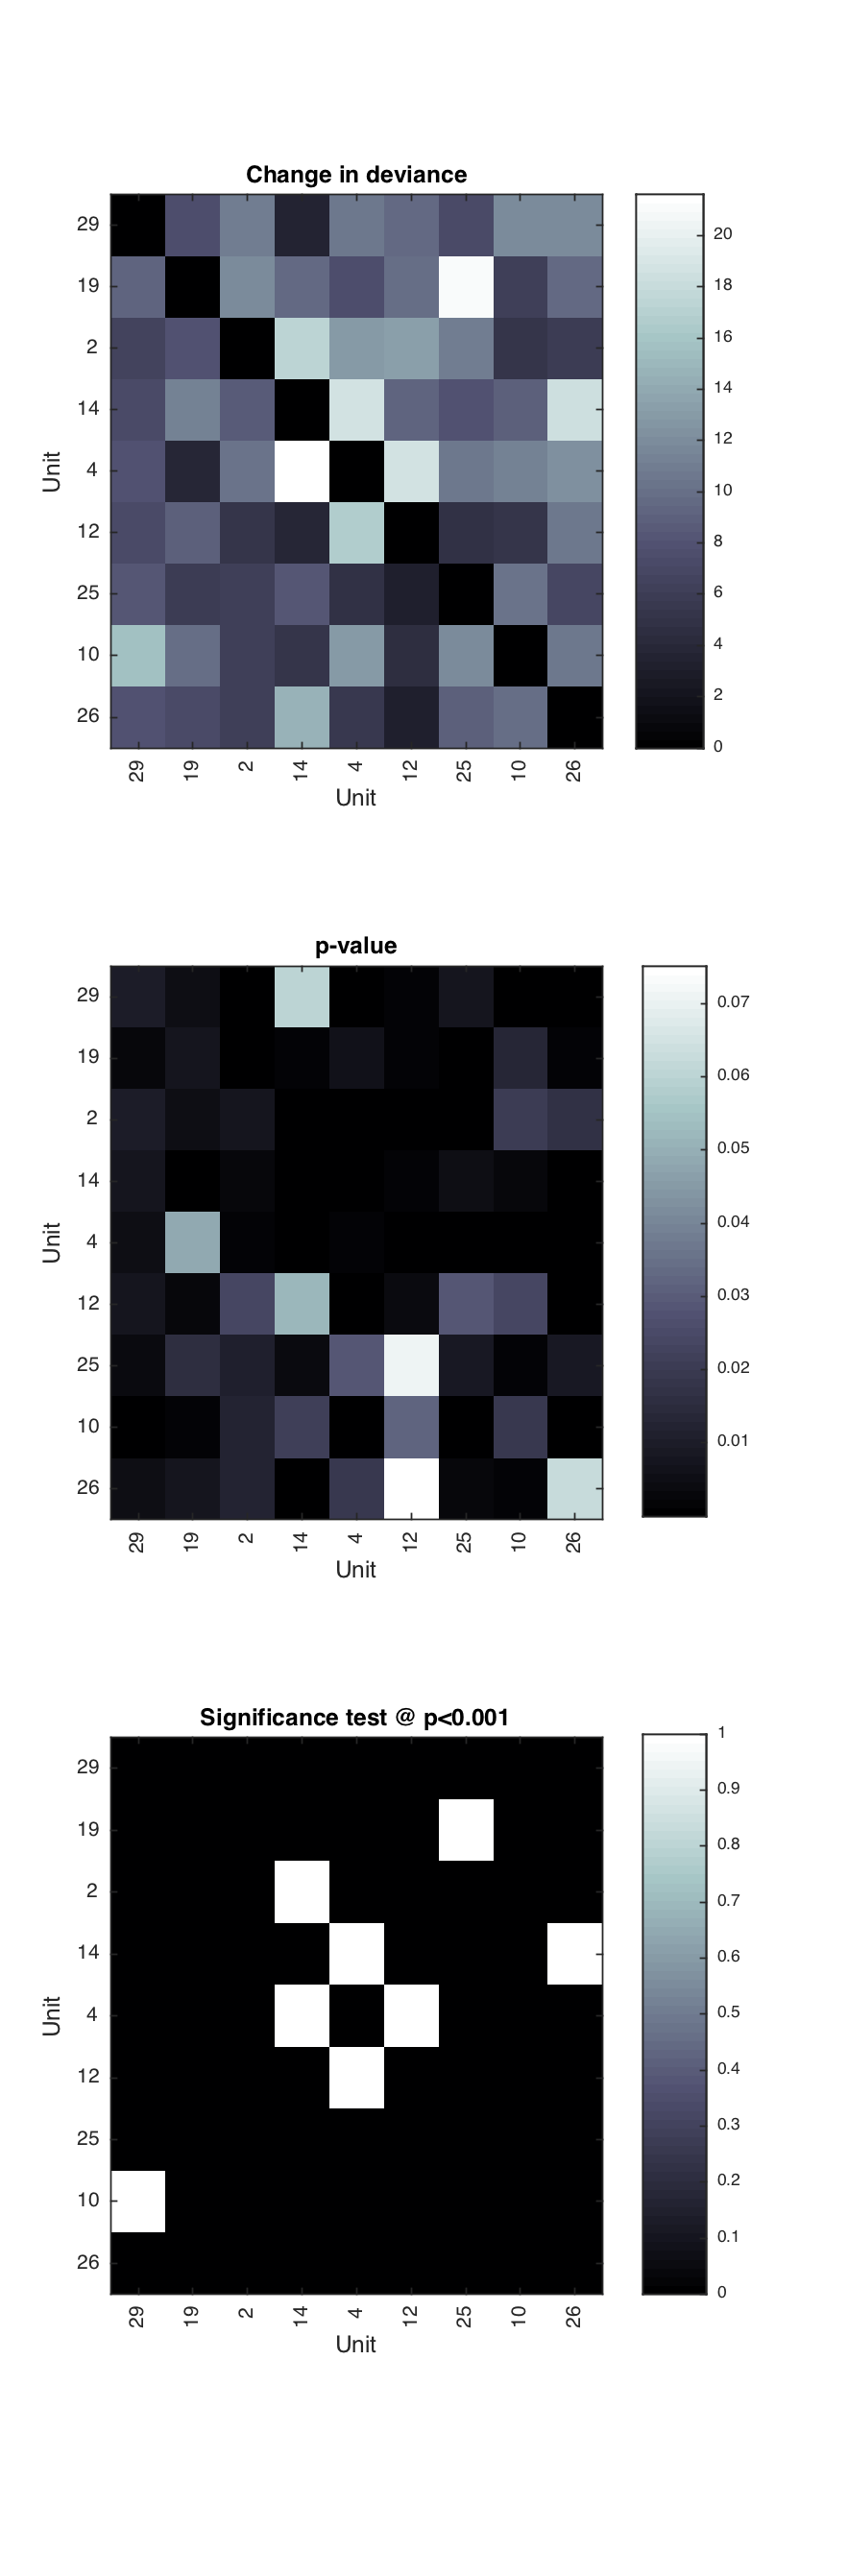

Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fitting unit 2
Fitting unit 3
Fitting unit 4
Fitting unit 5
Fitting unit 6
Fitting unit 7
Fitting unit 8
Fitting unit 9
Done
Fitting GLM by MLE with IRLS. Fitting 9 units.
Fitting unit 1
Fit

In [7]:
fn_out = 'invar_pred3_granger.eps';
granger(processed, data, fn_out);